In [1]:
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

from pathlib import Path
import pandas as pd
import os

In [2]:
class Cat_Dog_Dataset(Dataset):
    def __init__(self, csv,root_dir, transform=None):
        self.annonations = pd.read_csv(csv)
        self.transform = transform
        self.root = Path(str(root_dir))
                                       
    def __len__(self):
        return len(self.annonations) 
                                       
    def __getitem__(self, idx):
        img_path = self.root / self.annonations.iloc[idx, 0] 
        img = read_image(str(img_path))
        img = img / 255
        y_label = torch.tensor(int(self.annonations.iloc[idx, 1]))
        
        if self.transform:
            img = self.transform(img)
        return img, y_label

        

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# model_weights = models.GoogLeNet_Weights.DEFAULT
model_weights = models.EfficientNet_B0_Weights.DEFAULT
model_weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [5]:
auto_transform = model_weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
# model = models.googlenet(weights=model_weights)
model = models.efficientnet_b0(weights=model_weights)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [8]:
for name, param in model.named_parameters():
    print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([8, 32, 1, 1])
torch.Size([8])
torch.Size([32, 8, 1, 1])
torch.Size([32])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([96, 16, 1, 1])
torch.Size([96])
torch.Size([96])
torch.Size([96, 1, 3, 3])
torch.Size([96])
torch.Size([96])
torch.Size([4, 96, 1, 1])
torch.Size([4])
torch.Size([96, 4, 1, 1])
torch.Size([96])
torch.Size([24, 96, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([144, 24, 1, 1])
torch.Size([144])
torch.Size([144])
torch.Size([144, 1, 3, 3])
torch.Size([144])
torch.Size([144])
torch.Size([6, 144, 1, 1])
torch.Size([6])
torch.Size([144, 6, 1, 1])
torch.Size([144])
torch.Size([24, 144, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([144, 24, 1, 1])
torch.Size([144])
torch.Size([144])
torch.Size([144, 1, 5, 5])
torch.Size([144])
torch.Size([144])
torch.Size([6, 144, 1, 1])
torch.Size([6])
torch.Size([144, 6, 

In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
from torchinfo import summary

summary(model,
       input_size=(2,3,256,256),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=15,
       row_settings=['var_names'],
       )

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [2, 3, 256, 256] [2, 1000]       --              False
├─Sequential (features)                                      [2, 3, 256, 256] [2, 1280, 8, 8] --              False
│    └─Conv2dNormActivation (0)                              [2, 3, 256, 256] [2, 32, 128, 128] --              False
│    │    └─Conv2d (0)                                       [2, 3, 256, 256] [2, 32, 128, 128] (864)           False
│    │    └─BatchNorm2d (1)                                  [2, 32, 128, 128] [2, 32, 128, 128] (64)            False
│    │    └─SiLU (2)                                         [2, 32, 128, 128] [2, 32, 128, 128] --              --
│    └─Sequential (1)                                        [2, 32, 128, 128] [2, 16, 128, 128] --              False
│    │    └─MBConv (0)                                     

In [11]:
for name, param in model.named_parameters():
    print(name)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.2.fc1.weight
features.2.0.block.2.fc1.bias
features.2.0.block.2.fc2.weight
features.2.0.block.2.fc2.bias
features.2.0.block.3.0.weight
features.2.0.block.3.1.weight
features.2.0.block.3.1.bias
features.2.1.block.0.0.weight
features.2.1.block.0.1.weight
features.2.1.block.0.1.bias
features.2.1.block.1.0.weight
features.2.1.block.1.1.weight
features.2.1.block.1.1.bias
features.2.1.block.2.fc1.weight
features.2.1.block.2.fc1.bias
features.2.1.blo

In [12]:
model.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [13]:
model.classifier[1] = nn.Linear(1280,2)
summary(model,
       input_size=(2,3,256,256),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=15,
       row_settings=['var_names'],
       )

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [2, 3, 256, 256] [2, 2]          --              Partial
├─Sequential (features)                                      [2, 3, 256, 256] [2, 1280, 8, 8] --              False
│    └─Conv2dNormActivation (0)                              [2, 3, 256, 256] [2, 32, 128, 128] --              False
│    │    └─Conv2d (0)                                       [2, 3, 256, 256] [2, 32, 128, 128] (864)           False
│    │    └─BatchNorm2d (1)                                  [2, 32, 128, 128] [2, 32, 128, 128] (64)            False
│    │    └─SiLU (2)                                         [2, 32, 128, 128] [2, 32, 128, 128] --              --
│    └─Sequential (1)                                        [2, 32, 128, 128] [2, 16, 128, 128] --              False
│    │    └─MBConv (0)                                   

In [14]:
# model.inception3a.branch4

In [15]:
##test the model quickly
a = torch.randn(2,3,256,256).to(device)
model(a)

tensor([[-0.1743, -0.0137],
        [ 0.1875,  0.2546]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
dataset = Cat_Dog_Dataset("cats_dogs.csv", "cats_dogs_resized", transform=auto_transform)
len(dataset)

10

In [17]:
train_sample, test_sample = int(0.5*len(dataset)), (len(dataset) - int(0.5*len(dataset)))
train_set, test_set = torch.utils.data.random_split(dataset, [train_sample, test_sample])
print(len(train_set))
dataset = {
    "train": train_set,
    "test": test_set
}
len(dataset["train"])

5


5

In [18]:
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCHS = 10

In [19]:
dataloader = {x:DataLoader(dataset[x], BATCH_SIZE ) for x in ["train", "test"]}
len(dataloader["train"])

3

In [20]:
len(dataloader["train"])

3

In [21]:
if (Path()/"saved_model.pth").is_file():
    print("loading model weights")
#     model.load_state_dict(torch.load(Path()/"saved_model.pth"))
    loaded_result = torch.load(Path()/"saved_model.pth")
    test_loss = loaded_result["test_loss"]
    train_loss = loaded_result["train_loss"]
    train_acc = loaded_result["train_acc"]
    test_acc = loaded_result["test_acc"]
    model.load_state_dict(loaded_result["model"])
    
else:
    print("training the model")
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}\n{'-'*10}")
        model.train()

        for i, (img, label) in enumerate(dataloader["train"]):
            img, label = img.to(device), label.to(device)

            logits = model(img)
            loss = loss_fn(logits, label)
            train_loss.append(loss.item())  

            pred_probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(pred_probs, dim=1)
            acc = torch.eq(preds, label).sum()/len(preds)
            train_acc.append(acc.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.inference_mode():
            for i, (X, y) in enumerate(dataloader["test"]):
                X, y = X.to(device), y.to(device)

                logits = model(img)
                loss = loss_fn(logits, label)
                test_loss.append(loss.item())

                pred_probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(pred_probs, dim=1)
                acc = torch.eq(preds, label).sum()/len(preds)
                test_acc.append(acc.item())



    #             if i % 2 == 0:
    #             print(f"batch index: {i} | loss: {loss} | acc: {acc}")

        train_loss_mean = torch.mean(torch.tensor(train_loss))
        test_loss_mean = torch.mean(torch.tensor(test_loss))
        train_acc_mean = torch.mean(torch.tensor(train_acc))
        test_acc_mean = torch.mean(torch.tensor(test_loss))
    #     loss_mean = sum(train_loss)/len(train_loss)

        print(f"train mean loss: {train_loss_mean:.4f} | train mean acc: {train_acc_mean:.4f}")
        print(f"test mean loss: {test_loss_mean:.4f} | test mean acc: {test_acc_mean:.4f}")
    result = {"model":model.state_dict(),
            "test_loss":test_loss,
             "train_loss":train_loss,
             "train_acc":train_acc,
             "test_acc":test_acc}    
    torch.save(result, Path()/"saved_model.pth")
    print("model weights saved")

training the model
epoch: 0
----------


C:\Users\pouya\AppData\Roaming\Python\Python39\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train mean loss: 0.7502 | train mean acc: 0.1667
test mean loss: 0.7111 | test mean acc: 0.7111
epoch: 1
----------
train mean loss: 0.7338 | train mean acc: 0.3333
test mean loss: 0.7060 | test mean acc: 0.7060
epoch: 2
----------
train mean loss: 0.7267 | train mean acc: 0.3889
test mean loss: 0.6896 | test mean acc: 0.6896
epoch: 3
----------
train mean loss: 0.7220 | train mean acc: 0.4583
test mean loss: 0.6766 | test mean acc: 0.6766
epoch: 4
----------
train mean loss: 0.7233 | train mean acc: 0.5000
test mean loss: 0.6667 | test mean acc: 0.6667
epoch: 5
----------
train mean loss: 0.7107 | train mean acc: 0.5556
test mean loss: 0.6575 | test mean acc: 0.6575
epoch: 6
----------
train mean loss: 0.7066 | train mean acc: 0.5714
test mean loss: 0.6518 | test mean acc: 0.6518
epoch: 7
----------
train mean loss: 0.7100 | train mean acc: 0.5625
test mean loss: 0.6447 | test mean acc: 0.6447
epoch: 8
----------
train mean loss: 0.7036 | train mean acc: 0.5556
test mean loss: 0.6388 

In [22]:
model.eval()
with torch.inference_mode():
    pred_labels = []
    for i, (X, y) in enumerate(dataloader["test"]):
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)
#             test_loss.append(loss.item())

        pred_probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(pred_probs, dim=1)
        acc = torch.eq(preds, y).sum()/len(preds)
        
        pred_labels.append(preds.cpu())
        
pred_labels
pred_labels_tensor = torch.cat(pred_labels)
pred_labels_tensor
#             test_acc.append(acc.item())

tensor([0, 1, 0, 1, 1])

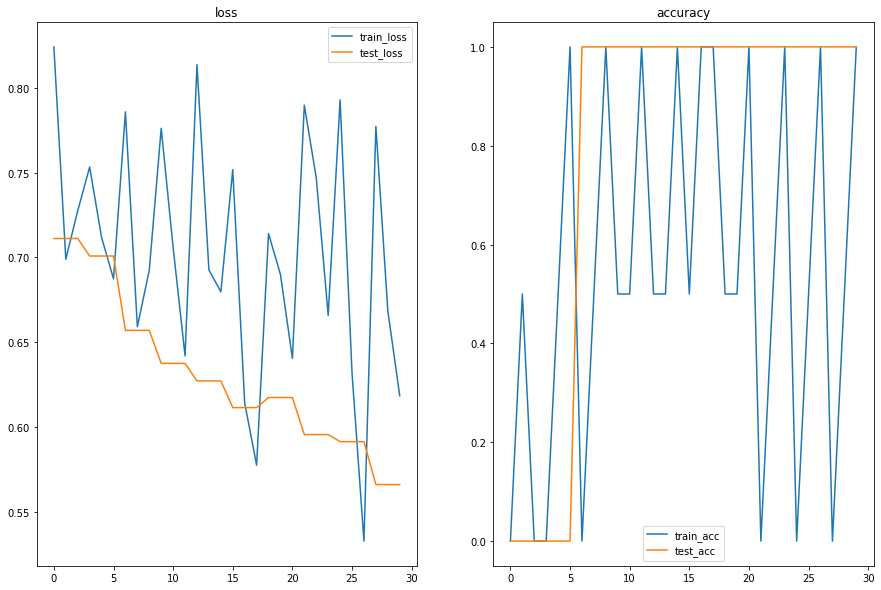

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.plot(range(len(test_loss)), train_loss, label = "train_loss")
plt.plot(range(len(test_loss)), test_loss, label = "test_loss")
plt.title("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(test_loss)), train_acc, label = "train_acc")
plt.plot(range(len(test_loss)), test_acc, label = "test_acc")
plt.title("accuracy")
plt.legend();

In [24]:
len(dataloader["test"])

3

In [25]:
truth = [y for x,y in dataloader["test"]]  
truth = torch.cat(truth)
truth

C:\Users\pouya\AppData\Roaming\Python\Python39\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([0, 0, 0, 0, 0])

In [26]:
# testing
for root, subdir, file in os.walk(Path()):
    print(file)

['cats_dogs.csv', 'custom_dataset.ipynb', 'custom_dataset.py', 'saved_model.pth']
['custom_dataset-checkpoint.ipynb']
['cat.0.jpg', 'cat.1.jpg', 'cat.2.jpg', 'cat.3.jpg', 'cat.4.jpg', 'cat.5.jpg', 'cat.6.jpg', 'cat.7.jpg', 'dog.0.jpg', 'dog.1.jpg']
['custom_dataset.cpython-39.pyc']


In [27]:
for file in os.listdir(Path()/"cats_dogs_resized"):
#     if file.startswith("c"):
        print(file)

cat.0.jpg
cat.1.jpg
cat.2.jpg
cat.3.jpg
cat.4.jpg
cat.5.jpg
cat.6.jpg
cat.7.jpg
dog.0.jpg
dog.1.jpg
